
## Harmonic oscillator (min T) including a control loss region (initial problem)

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min  T, \\[0.5em]
        \dot{x}_1(t) = x_2(t), \; t\in [0,T]\\[0.5em]
        \dot{x}_2(t) = u(t)-x_1(t), t\in [0,T]  \\[0.5em]
        u(t) \in [-1, 1], \; t\in [0,T]\\[0.5em]
        x(0) = (4.2,0) , \quad x(T) = 0_{\mathrm{R}^2}, \\[0.5em]
        \{x \mid x_2 < 0\} \text{ is a control loss reigon.}
    \end{array}
    \right.
$$

## Harmonic oscillator (min T) including a control loss region (regularized problem)

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min  T + \varepsilon \int_0^T v^2(t)dt + \int_0^T f_{NC}(x_2(t))u^2(t)dt, \\[0.5em]
        \dot{x}_1(t) = x_2(t), \; t\in [0,T]\\[0.5em]
        \dot{x}_2(t) =f_{C}(x_2(t))(u(t) - x_1(t)) + f_{NC}(x_2(t))(\lambda(t) - x_1(t))
        , t\in [0,T]  \\[0.5em]
        \dot{\lambda}(t) = f_C(x_2(t))v(t),\; t\in [0,T]\\[0.5em]
        u(t) \in [-1, 1] \; t\in [0,T]\\[0.5em]
        x(0) = (4.2,0) , \quad x(T) = 0_{\mathrm{R}^2}.
    \end{array}
    \right.
$$


In [125]:
using JuMP  
using Ipopt
using Plots
using LaTeXStrings
using Plots.PlotMeasures

In [126]:
mutable struct Direct
    t; x1; x2 ; λ ; u ; xu ; xv ; p1 ; p2
end

mutable struct DirecttSol
    t; x1; x2 ; λ ; u ; v ; xu ; xv ; p1 ; p2 ; p3
end


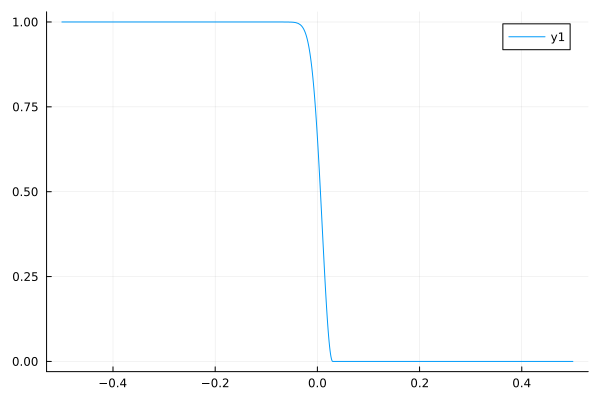

In [127]:
distance_squared(x, a) = x < a ? (a - x)^2 : 0 ;

#Moreau Yosida regularization

function MY_reg(x, a, k)
    return 1 - exp(-k*distance_squared(x, a))
end

fNC(x) = MY_reg(x, 0.03, 1200)
fC(x) = 1. - fNC(x)

plot(fNC, -0.5, 0.5)

In [128]:
#function F(x, alpha, a)
#    return 1 / (1 + exp(alpha * (x - a)))
#end
#fNC1(x)  = F(x, 100, 0.0)
#fC1(x)   = 1. - F(x, 100, 0.0)
#g(x)     = fNC(x) - fNC1(x) 
#plot(g, -0.5, 0.5)

In [129]:
function HO(ε=1e-3; x0=[2.5, 4], nsteps=800, tol=1e-8, display=true)
    """
        Solve the HO problem with the given parameters.

        Parameters
        ----------

        x0 : array of floats
            Initial condition
        nsteps : int
            Number of steps in the discretization
        ε : float
            Regularization parameter
        tol : float
            Tolerance for the solver
        display : bool
            If true, display the results

        Returns
        -------
        
        sol : DirecttSol
            The (direct) solution of the problem
            """



    # Create JuMP model, using Ipopt as the solver
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => display ? 5 : 1))
    set_optimizer_attribute(sys,"tol", tol)
    set_optimizer_attribute(sys,"constr_viol_tol", tol)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    # Constants
    N  = nsteps     # Grid size
    
    @variables(sys, begin
                 x1[1:N+1]    
                 x2[1:N+1]   
         -1.0  ≤  λ[1:N+1]  ≤ 1.0
         -1.0  ≤  u[1:N+1]  ≤ 1.0
          0.0  ≤ Δt         ≤ 1.0 
                  v[1:N+1] 
         -1e1  ≤ xv[1:N+1]
         -1e1  ≤ xu[1:N+1]
    end)
    
    set_start_value(Δt, 20/N);
    for i in 1:N+1
        set_start_value(λ[i] , 1.0);
        set_start_value(v[i] , 0.0);
        set_start_value(xv[i], 0.0);
        set_start_value(xu[i], 0.0);
    end
    
    T = Δt*(N+1) ;
    
    # Objective
    @objective(sys, Min, T + ε*xv[N+1] + xu[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0.0
        con_xv0, xv[1]   == 0.0
        con_x10, x1[1]   == x0[1] 
        con_x20, x2[1]   == x0[2] 
        con_x1f, x1[N+1] == 0.0 
        con_x2f, x2[N+1] == -1e-5
    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j])
    @NLexpression(sys, dx2[j = 1:N+1], fC(x2[j])*u[j] +fNC(x2[j])*λ[j] - x1[j])
    @NLexpression(sys,  dλ[j = 1:N+1], fC(x2[j])*v[j])
    @NLexpression(sys, dxv[j = 1:N+1], v[j]^2)
    @NLexpression(sys, dxu[j = 1:N+1], fNC(x2[j])*u[j]^2)
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1]  + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end)
    
    
    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    λ  = value.(λ)[:]
    u  = value.(u)[:]
    v  = value.(v)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t  = (0:N) * value.(Δt)
    
    
    px10 = - dual(con_x10)
    px20 = - dual(con_x20)
    px1f =   dual(con_x1f)                                 
    px2f =   dual(con_x2f) 
    
    px30 = 0 # λ(0) is free
    px3f = 0 # λ(T) is free

  
    # duals of the dynamics
    px1 = -[ dual(con_dx1[i]) for i in 1:N ]
    px2 = -[ dual(con_dx2[i]) for i in 1:N ]
    px3 = -[ dual(con_dx3[i]) for i in 1:N ]

    # adjoint vectors
    p1 = [px10; (px1[1:N-1]+px1[2:N])/2; px1f]
    p2 = [px20; (px2[1:N-1]+px2[2:N])/2; px2f]
    p3 = [px30; (px3[1:N-1]+px3[2:N])/2; px3f]
    
    
    
    return DirecttSol(t, x1, x2, λ, u, v, xu, xv, p1, p2, p3)
    
    
end;
     


In [130]:
# Resolution
ε   = 1e-3
sol = HO(ε);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    26406
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    69600

Total number of variables............................:     5608
                     variables with only lower bounds:     1602
                variables with lower and upper bounds:     1603
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4006
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0025000e+01 4.00e+00 4.01e-03  -1.0 0.00e+00    -  0.00e+00

┌ Warning: Function fNC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fNC, 1, fNC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370
┌ Warning: Function fC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fC, 1, fC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


xu = 0.0018211356466179204
xv = 0.05645712669811409


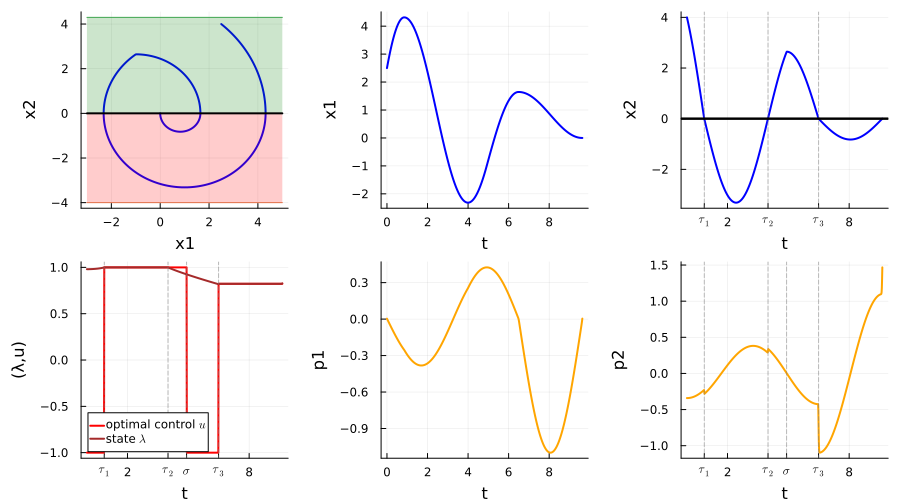

In [131]:
# Plots
t  = sol.t
x1 = sol.x1
x2 = sol.x2
λ  = sol.λ
u  = sol.u
v  = sol.v
xu = sol.xu
xv = sol.xv
p1 = sol.p1
p2 = sol.p2
p3 = sol.p3

println("xu = ", xu[end])
println("xv = ", xv[end])

# Compute the differences between adjacent elements
d = diff(u)

switchings = findall(abs.(x2) .< 0.012)
tc1   = t[switchings[1]]
tc2   = t[switchings[2]]
tc3   = t[switchings[3]]
tstar = t[findall(abs.(d) .> 1.5)[]]

T  = t[end];



x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",   legend=false,  linecolor=:blue , linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",    legend=false,  linecolor=:blue , linewidth=2)
xticks!(x2_plot, [tc1,2.,tc2,tc3,8.], [L"$\tau_1$","2",L"$\tau_2$",L"$\tau_3$", "8"])
vline!(x2_plot, [tc1], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(x2_plot, [tc2], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(x2_plot, [tc3], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
hline!([(0., 0), (31., 0)], linecolor=:black, linewidth=2, label=false)


u1 = copy(u) ;

u1[tc1  .<= t .<= tc2] .= λ[(switchings[1] + switchings[2]) ÷ 2]
u1[tc3 .<= t .<=   T] .= λ[(switchings[4] + length(t)) ÷ 2]

control_plot = plot(t, u1,  xlabel = "t", label=L"optimal control $u$",linecolor=:red ,linewidth=2,legend=:bottomleft) 
plot!(t, λ, xlabel = "t", ylabel = "(λ,u)",  label =L"state $\lambda$", linecolor=:brown,linewidth=2)
xticks!(control_plot, [tc1,2.,tc2,tstar,tc3,8.], [L"$\tau_1$","2",L"$\tau_2$",L"$\sigma$",L"$\tau_3$", "8"])
vline!(control_plot, [tc1], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(control_plot, [tc2], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(control_plot, [tc3], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(control_plot, [tstar], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)


x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend=false,  linecolor=:blue , linewidth=2)
plot!(x1x2_plot, [-3, 5], [-4.0, -4.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :red, label=false)
plot!(x1x2_plot, [-3, 5], [4.3, 4.3], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green, label=false)
plot!(x1x2_plot, [-3, 5], [0., 0.], linecolor=:black, linewidth=2, label=false)

λ_plot = plot(t, λ, xlabel = "x1", ylabel = "λ",  legend = false)

p1_plot   = plot(t, p1, xlabel = "t", ylabel = "p1",  legend=false, linecolor=:orange , linewidth=2)
p2_plot   = plot(t, p2, xlabel = "t", ylabel = "p2",  legend=false, linecolor=:orange , linewidth=2)
xticks!(p2_plot, [tc1,2,tc2,tstar,tc3,8], [L"$\tau_1$","2",L"$\tau_2$",L"$\sigma$",L"$\tau_3$","8"])
vline!(p2_plot, [tc1], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(p2_plot, [tc2], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(p2_plot, [tc3], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(p2_plot, [tstar], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)



plot(x1x2_plot, x1_plot,x2_plot, control_plot , p1_plot,p2_plot, layout = (2,3), size=(900, 500), left_margin=5mm)

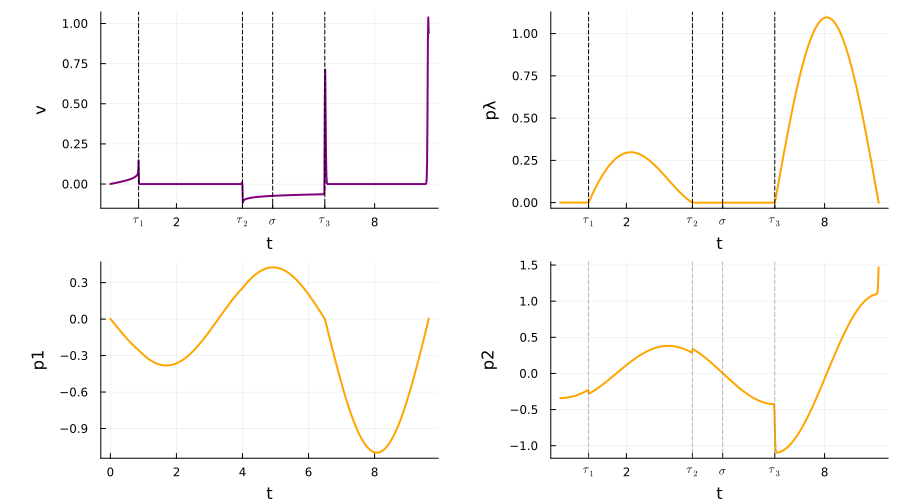

In [132]:
v_plot   = plot(t,  v, xlabel = "t", ylabel = "v",  legend =false,linecolor=:purple, linewidth=2)
xticks!(v_plot, [tc1,2.,tc2,tstar,tc3,8.], [L"$\tau_1$","2",L"$\tau_2$",L"$\sigma$",L"$\tau_3$", "8"])
vline!(v_plot, [tc1], linestyle=:dash, linecolor=:black, label=nothing)
vline!(v_plot, [tc2], linestyle=:dash, linecolor=:black, label=nothing)
vline!(v_plot, [tc3], linestyle=:dash, linecolor=:black, label=nothing)
vline!(v_plot, [tstar], linestyle=:dash, linecolor=:black, label=nothing)

p3_plot   = plot(t, p3, xlabel = "t", ylabel = "pλ",  legend=false, linecolor=:orange , linewidth=2)
xticks!(p3_plot, [tc1,2.,tc2,tstar,tc3,8.], [L"$\tau_1$","2",L"$\tau_2$",L"$\sigma$",L"$\tau_3$", "8"])
vline!(p3_plot, [tc1], linestyle=:dash, linecolor=:black, label=nothing)
vline!(p3_plot, [tc2], linestyle=:dash, linecolor=:black, label=nothing)
vline!(p3_plot, [tc3], linestyle=:dash, linecolor=:black, label=nothing)
vline!(p3_plot, [tstar], linestyle=:dash, linecolor=:black, label=nothing)

plot(v_plot,p3_plot ,p1_plot,p2_plot, layout = (2,2), size=(900, 500), left_margin=10mm)

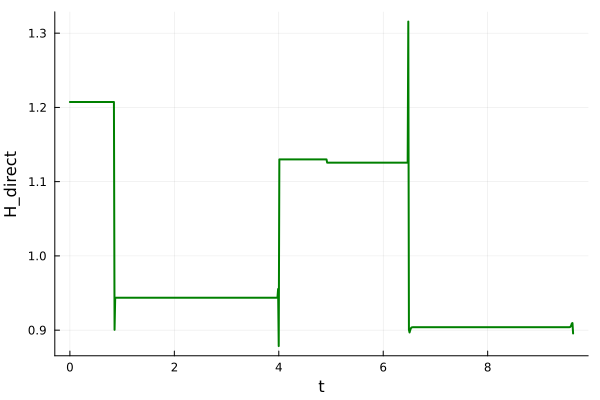

In [133]:
function H(k)
    return (p1[k] * x2[k]) + (p2[k] * (fC(x2[k])*u[k] +fNC(x2[k])*λ[k] - x1[k])) + p3[k]*fC(x2[k])*v[k] - ε * (v[k])^2 - fNC(x2[k]) * (u[k])^2
end
H_direct  = [H(k) for k in 1:length(x1)]
ph_plot   = plot(t, H_direct, xlabel = "t", ylabel = "H_direct",  legend=false, linecolor=:green , linewidth=2)


In [134]:
jmp1 = -(p2[switchings[1]+3] - p2[switchings[1]-2]) 
jmp3 = -(p2[switchings[3]+3] - p2[switchings[3]-2])  
lambda = λ[(switchings[3] + length(t)) ÷ 2] 

println(" p2(t1+) - p2(t1-) = ", jmp1)
println(" p2(t3+) - p2(t3-) = ", jmp3)
println(" lambda(t3+) = ", lambda)

 p2(t1+) - p2(t1-) = 0.0422953742021801
 p2(t3+) - p2(t3-) = 0.6585522616432022
 lambda(t3+) = 0.8228634759335799


# Indirect method

In [135]:
using NLsolve
using Plots
using Plots.PlotMeasures
include("flow.jl");

In [136]:
# Dynamics
function F0(x)
    return [ x[2], -x[1]]
end

function F1(x)
    return [ 0.0 ,   1.0]
end


H0(x, p) = p' * F0(x) 
H1(x, p) = p' * F1(x)

# Hamiltonians: 
H(x, p, u)  =  H0(x, p) + u*H1(x,p)                             # pseudo-Hamiltonian

up(x, p) =   1.0
um(x, p) = - 1.0

Hp(x, p) = H(x, p, up(x, p))
Hm(x, p) = H(x, p, um(x, p))


# Hamiltonians: control loss region 2
H2(x, b, y, p)  = H0(x, p) + b*H1(x, p) - y*p[2]                # pseudo-Hamiltonian
Hcl(X, P)       = H2(X[1:2], X[3], X[4], P[1:2])                # control loss 2



# Flows
fp    = Flow(Hp)
fm    = Flow(Hm)
fcl   = Flow(Hcl) ;

In [137]:
t0 = 0.0
x0 = [2.5; 4.0]

# Shooting function
function SHOOT(p0, tt1, tt2, ttstar, tt3, b1, jump1, jump2, TT) 
    
    pb0    = 0.0 
    py0    = 0.0
        
    x1, p1 = fm(t0 , x0, p0, tt1) 
    
    x2, p2 = fp(tt1, x1, p1 - [0. , jump1], tt2)
    
    x3, p3 = fp(tt2, x2, p2, ttstar)
    
    x4, p4 = fm(ttstar, x3, p3, tt3)
    
    X5, P5 = fcl(tt3, [x4 ; b1 ; 0.0], [p4 - [0. , jump2]; pb0 ; py0], TT)

         s = zeros(eltype(p0), 10)
    
    s[1:2]  = X5[1:2] - [ 0.0 , 0.0 ]                     # target
    s[3]    = H1(x3, p3)                                  # switching
    s[4]    = x1[2] - 0.0                                 # first crossing 
    s[5]    = x2[2] - 0.0                                 # second crossing 
    s[6]    = x4[2] - 0.0                                 # third crossing 
    s[7]    = jump1 - p1[2]*(1. + 1.)/(1. - x1[1])        # jump1
    s[8]    = jump2 - p4[2]*(b1 + 1.)/(b1 - x4[1])        # jump2
    s[9]    = Hm(x0, p0) - 1.0                            # free final time
    s[10]   = P5[4]                                       # averaged gradient condition 

    return s

end;

In [138]:
S(ξ) = SHOOT(ξ[1:2], ξ[3], ξ[4], ξ[5],ξ[6],ξ[7],ξ[8], ξ[9], ξ[10]);

In [139]:
ξ_guess = [p1[1] , p2[1], tc1, tc2, tstar , tc3, lambda, jmp1, jmp3, t[end]]; # initial guess

In [140]:
S(ξ_guess)

10-element Vector{Float64}:
  0.0030303955667263065
  0.019026063721736684
 -0.03909148018729758
 -0.017072609261357643
  0.024005944865149276
 -0.01731135227352269
 -0.09425089626349506
 -0.15946206847411137
  0.20729733354209312
  0.08553275799649465

In [141]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0     = indirect_sol.zero[1:2]
    tt1     = indirect_sol.zero[3]
    tt2     = indirect_sol.zero[4]
    ttstar  = indirect_sol.zero[5]
    tt3     = indirect_sol.zero[6]
    b11     = indirect_sol.zero[7]
    jmp1    = indirect_sol.zero[8]
    jmp2    = indirect_sol.zero[9]
    T1      = indirect_sol.zero[10]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.072973e-01              NaN
     1     2.139645e-04     1.992346e-01
     2     5.293179e-07     1.052616e-03
     3     1.025846e-13     3.874358e-07
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.003610344941276606, -0.34081598679342473, 0.8551784446588617, 3.9988625862921423, 4.914264865081909, 6.4921293193116405, 0.8228634759335799, 0.0422953742021801, 0.6585522616432022, 9.635813460944922]
 * Zero: [-0.008674974293906436, -0.2956285420501788, 0.8519663271732714, 3.9935589807630585, 4.916716539422637, 6.4875128662175205, 0.8219028306316266, 0.11350831730750106, 0.8384462105283497, 9.629105519807315]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4


In [142]:
t0 = 0.0
x0 = [2.5; 4.0]

ode_sol = fm((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1    = ode_sol.t ;
xx1     = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1     = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1     = um.(xx1, pp1);

ode_sol = fp((tt1, tt2), xx1[end], pp1[end] - [0., jmp1], saveat=0.1) ;
ttt2    = ode_sol.t ;
xx2     = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ] ;
pp2     = [ ode_sol[3:4, j] for j in 1:size(ttt2, 1) ] ;
uu2     = up.(xx2, pp2)  ;

ode_sol = fp((tt2, ttstar), xx2[end], pp2[end] , saveat=0.1) ;
ttt3    = ode_sol.t ;
xx3     = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ] ;
pp3     = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] ;
uu3     = up.(xx3, pp3)  ;


ode_sol = fm((ttstar, tt3), xx3[end], pp3[end], saveat=0.1) ;
ttt4    = ode_sol.t ;
xx4     = [ ode_sol[1:2, j] for j in 1:size(ttt4, 1) ] ;
pp4     = [ ode_sol[3:4, j] for j in 1:size(ttt4, 1) ] ;
uu4     = um.(xx4, pp4)  ;

ode_sol = fcl((tt3, T1), [xx4[end] ; b11 ; 0.0], [pp4[end] - [0., jmp2]; 0. ; 0.], saveat=0.1)
ttt5    = ode_sol.t
xx5     = [ ode_sol[1:2, j] for j in 1:size(ttt5, 1) ]
pp5     = [ ode_sol[5:6, j] for j in 1:size(ttt5, 1) ] 
uu5     = b11.*ones(length(ttt5)) ;


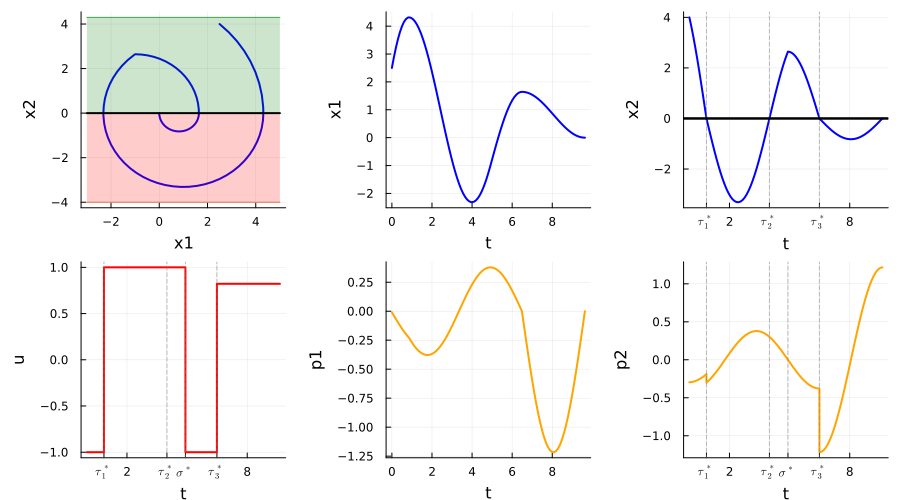

In [143]:
t = [ ttt1 ; ttt2 ; ttt3 ; ttt4 ; ttt5 ]
x = [ xx1 ; xx2 ; xx3 ; xx4 ; xx5 ]
p = [ pp1 ; pp2 ; pp3 ; pp4 ; pp5 ]
u = [ uu1 ; uu2 ; uu3 ; uu4 ; uu5 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1" ,legend=false,  linecolor=:blue , linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2" ,legend=false,  linecolor=:blue , linewidth=2)
xticks!(x2_plot, [ttt1[end],2,ttt2[end],ttt4[end],8], [L"$\tau_1^*$","2",L"$\tau_2^*$",L"$\tau_3^*$","8"])
vline!(x2_plot, [ttt1[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(x2_plot, [ttt2[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(x2_plot, [ttt4[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
hline!([(0., 0), (31., 0)], linecolor=:black, linewidth=2, label=false)

p1_plot   = plot(t,  p1,xlabel = "t", ylabel = "p1", legend=false, linecolor=:orange , linewidth=2)
p2_plot   = plot(t,  p2,xlabel = "t", ylabel = "p2", legend=false,  linecolor=:orange , linewidth=2)
xticks!(p2_plot, [ttt1[end],2,ttt2[end],ttt3[end],ttt4[end],8], [L"$\tau_1^*$","2",L"$\tau_2^*$",L"$\sigma^*$",L"$\tau_3^*$","8"])
vline!(p2_plot, [ttt1[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(p2_plot, [ttt2[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(p2_plot, [ttt4[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(p2_plot, [ttt3[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)

u_plot    = plot(t,   u,xlabel = "t", ylabel = "u", legend=false,  linecolor=:red , linewidth=2) #, linetype=:steppre)
xticks!(u_plot, [ttt1[end],2,ttt2[end],ttt3[end],ttt4[end],8], [L"$\tau_1^*$","2",L"$\tau_2^*$",L"$\sigma^*$",L"$\tau_3^*$","8"])
vline!(u_plot, [ttt1[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(u_plot, [ttt2[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(u_plot, [ttt3[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)
vline!(u_plot, [ttt4[end]], linestyle=:dash, linecolor=RGBA(0.5, 0.5, 0.5, 0.5), label=nothing)

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",legend=false,  linecolor=:blue , linewidth=2)
plot!(x1x2_plot, [-3, 5], [-4.0, -4.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :red, label=false)
plot!(x1x2_plot, [-3, 5], [4.3, 4.3], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green, label=false)
plot!(x1x2_plot, [-3, 5], [0., 0.], linecolor=:black, linewidth=2, label=false)

x=plot( x1x2_plot, x1_plot,x2_plot, u_plot , p1_plot,p2_plot, layout = (2,3), size=(900, 500), left_margin=5mm)

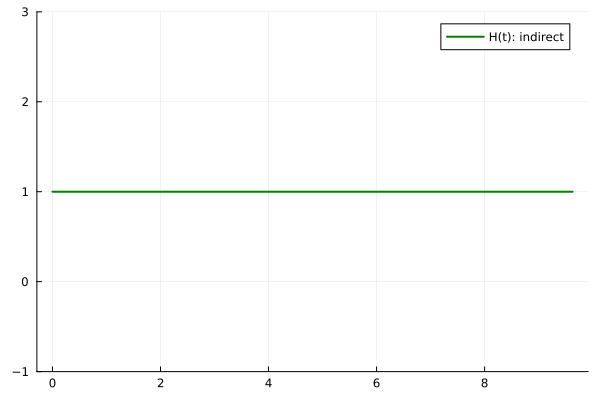

In [144]:
function HH(k)
    return p1[k] * x2[k] + p2[k] * (u[k] - x1[k]) 
end
H_indirect  = [HH(k) for k in 1:length(x2)]
ph_plot   = plot(t, H_indirect, label = "H(t): indirect", linecolor=:green , linewidth=2, ylims=(-1, 3))

In [145]:
function trapezoidal_integral(p, tt)
    integral = 0.0
    for i in 1:(length(tt) - 1)
        integral += (p[i] + p[i + 1]) * (tt[i + 1] - tt[i]) / 2
    end
    return integral
end
p2NC = [v[2] for v in pp2]
trapezoidal_integral(p2NC, ttt2)

0.45601971559766336

In [146]:
# create an animation
animx = @animate for i = 1:length(t)
    plot(x1[1:i], x2[1:i], xlim=(-3.,5.), ylim=(-4.,4.3), xlabel="x1", ylabel="x2", label="optimal trajectory \$x\$", linecolor=:blue,  linewidth=2)
    scatter!([x1[i]], [x2[i]], markersize=4, marker=:circle, color=:black, label=false)
    plot!( [-3, 5], [-4.0, -4.0], fillrange = 0.0, fillalpha = 0.2, fillcolor = :red, label=false)
    plot!( [-3, 5], [4.3, 4.3], fillrange = 0.0, fillalpha = 0.2, fillcolor = :green, label=false)
    plot!( [-3, 5], [0., 0.], linecolor=:black, linewidth=2, label=false)
    
end

# create an animation
animu = @animate for i = 1:length(t)
    plot(t[1:i], u[1:i], xlim=(0.,t[end]), ylim=(-1.2,1.2), xlabel="t", ylabel="u", label="opitmal control \$u\$", linecolor=:red,  linewidth=2)
end ;

# create an animation
animp1 = @animate for i = 1:length(t)
    plot(t[1:i], p1[1:i], xlim=(0.,t[end]), ylim=(-1.3, 0.5), xlabel="t", ylabel="p1", label="adjoint vector \$p1\$", linecolor=:orange,  linewidth=2)
end ;

# create an animation
animp2 = @animate for i = 1:length(t)
    plot(t[1:i], p2[1:i], xlim=(0.,t[end]), ylim=(-1.5,1.3), xlabel="t", ylabel="p2", label="adjoint vector \$p2\$", linecolor=:orange,  linewidth=2)
end ;

[ Info: Saved animation to /home/anas/Documents/control-loss/harmonic oscillator/ho_x.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/harmonic oscillator/ho_x.gif")
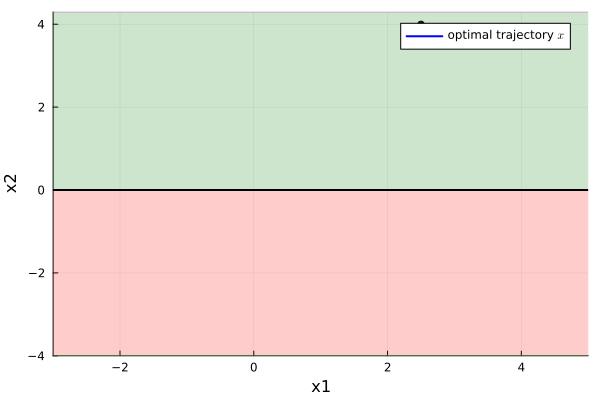

In [147]:

# display the animation
gif(animx, "ho_x.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/harmonic oscillator/ho_u.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/harmonic oscillator/ho_u.gif")
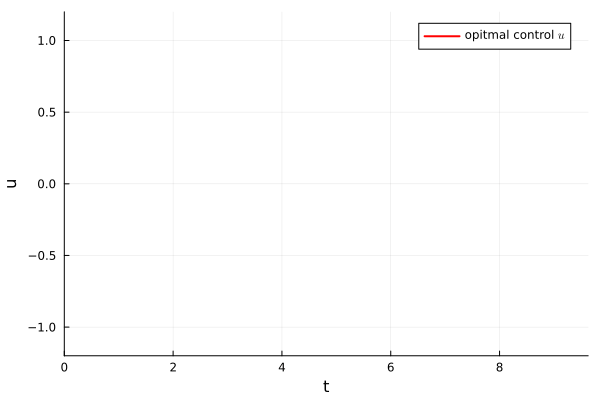

In [148]:
# display the animation
gif(animu, "ho_u.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/harmonic oscillator/ho_p1.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/harmonic oscillator/ho_p1.gif")
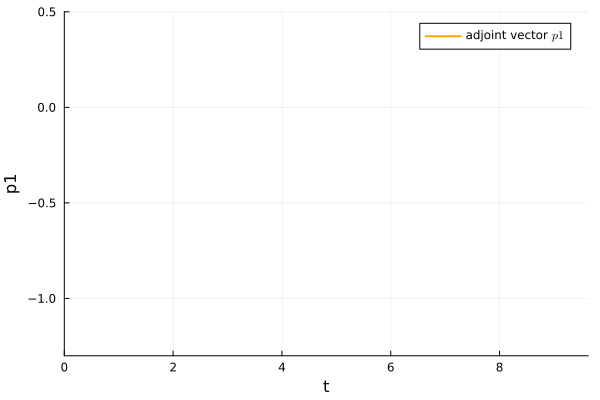

In [149]:
# display the animation
gif(animp1, "ho_p1.gif", fps = 10)

[ Info: Saved animation to /home/anas/Documents/control-loss/harmonic oscillator/ho_p2.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/harmonic oscillator/ho_p2.gif")
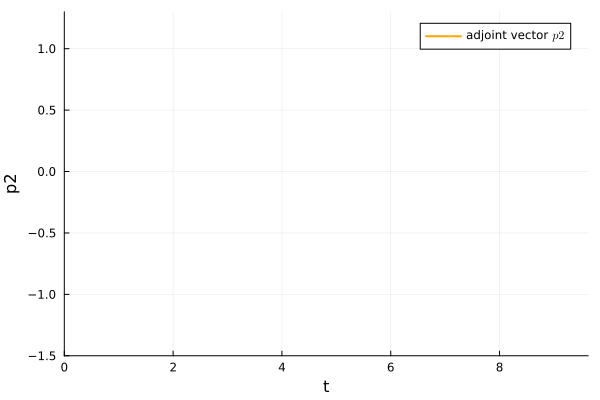

In [150]:
# display the animation
gif(animp2, "ho_p2.gif", fps = 10)